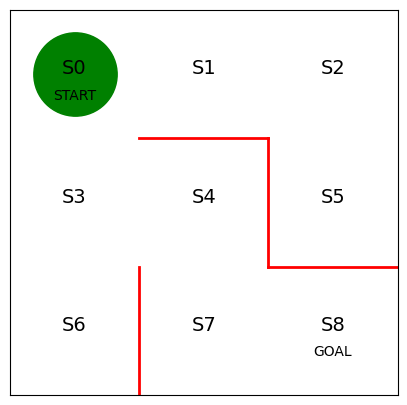

In [1]:
# 정책 경사 알고리즘으로 구현한 미로 탐색
# 정책을 최적화하는 목표함수를 미분해서 그 미분값에 따라 정책을 업데이트
# 경사상승법(Gradient Ascent) 
##############################
#앞과 같은 코드
# 초기 상태의 미로 모습
import matplotlib.pyplot as plt
# 전체 그림의 크기 및 그림을 나타내는 변수 선언
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

# 붉은 벽 그리기
plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

# 상태를 의미하는 문자열(S0~S8) 표시
#ha: horizontal alignment
plt.text(0.5, 2.5, 'S0', size=14, ha='center') 
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')
# 그림을 그릴 범위 및 눈금 제거 설정
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
# S0에 녹색 원으로 현재 위치를 표시
line, = ax.plot([0.5], [2.5], marker="o", color='g', markersize=60)

In [2]:
#앞과 같은 코드
import numpy as np
# 정책(policy) : 에이전시가 어떻게 행동할지 결정하는 규칙
# 정책을 결정하는 파라미터의 초기값 theta_0를 설정
# row : 상태 0~7
# col : 행동방향(시계방향 - 상,우,하,좌)
theta_0 = np.array([[np.nan, 1, 1, np.nan],  # s0
                    [np.nan, 1, np.nan, 1],  # s1
                    [np.nan, np.nan, 1, 1],  # s2
                    [1, 1, 1, np.nan],  # s3
                    [np.nan, np.nan, 1, 1],  # s4
                    [1, np.nan, np.nan, np.nan],  # s5
                    [1, np.nan, np.nan, np.nan],  # s6
                    [1, 1, np.nan, np.nan],  # s7 
                    ])
#s1에서는 오른쪽과 아래쪽으로만 이동할 수 있음
#s8은 목표지점이므로 정책이 없음     

In [3]:
# 정책 파라미터 theta를 행동정책 pi로 변환(소프트맥스 함수 사용)하는 함수
# 비율 계산에 소프트맥스 함수 사용
def softmax_convert_into_pi_from_theta(theta):
    beta = 1.0
    # theta의 행렬 크기를 구함
    [m, n] = theta.shape  
    pi = np.zeros((m, n))

    # theta를 exp(theta)로 변환
    exp_theta = np.exp(beta * theta)  

    for i in range(0, m):
        # 단순 비율이 아닌 softmax로 계산하는 코드
        pi[i, :] = exp_theta[i, :] / np.nansum(exp_theta[i, :])        

    pi = np.nan_to_num(pi)  # nan을 0으로 변환

    return pi

# 초기 정책 pi_0을 계산(초기값은 랜덤과 동일함)
pi_0 = softmax_convert_into_pi_from_theta(theta_0)
print(pi_0)    

[[0.         0.5        0.5        0.        ]
 [0.         0.5        0.         0.5       ]
 [0.         0.         0.5        0.5       ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.         0.5        0.5       ]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.5        0.5        0.         0.        ]]


In [4]:
# 행동 a를 취한 후의 상태 s를 구하는 함수
def get_action_and_next_s(pi, s):
    direction = ["up", "right", "down", "left"]
    # pi[s,:]의 확률을 따라, direction값이 선택된다
    next_direction = np.random.choice(direction, p=pi[s, :])

    if next_direction == "up":
        action = 0
        s_next = s - 3  # 위로 이동하면 상태값이 3 줄어든다
    elif next_direction == "right":
        action = 1
        s_next = s + 1  # 오른쪽으로 이동하면 상태값이 1 늘어난다
    elif next_direction == "down":
        action = 2
        s_next = s + 3  # 아래로 이동하면 상태값이 3 늘어난다
    elif next_direction == "left":
        action = 3
        s_next = s - 1  # 왼쪽으로 이동하면 상태값이 1 줄어든다

    return [action, s_next]

In [5]:
# 미로를 빠져나오는 함수, 상태와 행동의 히스토리를 출력한다
def goal_maze_ret_s_a(pi):
    s = 0  # 시작 지점
    # 에이전트의 행동 및 상태의 히스토리를 기록하는 리스트
    s_a_history = [[0, np.nan]]  

    # 목표 지점에 이를 때까지 반복
    while True:   
        [action, next_s] = get_action_and_next_s(pi, s)
        # 현재 상태의 동작을(마지막이므로 인덱스가 -1) 히스토리에 추가
        s_a_history[-1][1] = action

        # 다음 상태를 히스토리에 추가, 행동은 아직 알 수 없으므로 nan으로 설정
        s_a_history.append([next_s, np.nan])

        # 목표 지점에 이르면 종료
        if next_s == 8:  
            break
        else:
            s = next_s

    return s_a_history

In [6]:
# 초기 정책으로 미로를 빠져나오기
s_a_history = goal_maze_ret_s_a(pi_0)
print(s_a_history)
print("목표 지점에 이르기까지 걸린 단계 수는 " + str(len(s_a_history) - 1) + "단계입니다")

[[0, 2], [3, 0], [0, 2], [3, 2], [6, 0], [3, 1], [4, 2], [7, 0], [4, 2], [7, 1], [8, nan]]
목표 지점에 이르기까지 걸린 단계 수는 10단계입니다


In [7]:


# 정책 경사 알고리즘으로 정책 수정
# theta를 수정하는 함수
def update_theta(theta, pi, s_a_history):
    # 학습률
    eta = 0.1 
    # 목표 지점에 이르기까지 걸린 단계 수
    T = len(s_a_history) - 1  

    # theta의 행렬 크기
    [m, n] = theta.shape  
    # delta_theta를 구하기 위해 원본 복사(넘파이는 계산을 빠르게 하기 위해 얕은 복사를 사용함)
    delta_theta = theta.copy()  

    # delta_theta를 요소 단위로 계산
    for i in range(0, m):
        for j in range(0, n):
            # theta가 nan이 아닌 경우
            if not(np.isnan(theta[i, j])):  
                # 히스토리에서 상태 i인 것만 모은 리스트
                SA_i = [SA for SA in s_a_history if SA[0] == i]
                
                # 상태 i에서 행동 j를 취한 경우만 모은 리스트
                SA_ij = [SA for SA in s_a_history if SA == [i, j]]
                
                # 상태 i에서 모든 행동을 취한 횟수
                N_i = len(SA_i)  
                # 상태 i에서 행동 j를 취한 횟수 
                N_ij = len(SA_ij)  
                
                delta_theta[i, j] = (N_ij - pi[i, j] * N_i)/T

    new_theta = theta + eta * delta_theta

    return new_theta


In [8]:
# 정책 경사 알고리즘으로 미로 빠져나오기

# 정책의 변화가 10^-4 보다 작아지면 학습을 종료
stop_epsilon = 10**-4  

theta = theta_0
pi = pi_0

is_continue = True
count = 1

# is_continue가 False가 될 때까지 반복
while is_continue:  
    # 정책 π를 따라 미로를 탐색한 히스토리를 구함
    s_a_history = goal_maze_ret_s_a(pi)  
    # 파라미터 Θ를 수정
    new_theta = update_theta(theta, pi, s_a_history)  
    # 정책 π를 수정
    new_pi = softmax_convert_into_pi_from_theta(new_theta)  

    # 정책의 변화를 출력
    print(np.sum(np.abs(new_pi - pi)))  
    # 목적지에 이르기까지 걸린 단계수 출력
    print("단계수: " + str(len(s_a_history) - 1))

    if np.sum(np.abs(new_pi - pi)) < stop_epsilon:
        is_continue = False
    else:
        theta = new_theta
        pi = new_pi

0.029451618726459683
단계수: 10
0.023130252405396234
단계수: 42
0.01380985284112568
단계수: 28
0.012212802514156629
단계수: 16
0.011562127037542391
단계수: 110
0.02247407712984345
단계수: 14
0.02441544340071533
단계수: 8
0.03199329414539076
단계수: 6
0.026662526896756966
단계수: 8
0.021896128924238256
단계수: 20
0.029364936918400197
단계수: 10
0.013451048981138247
단계수: 76
0.007892292627293573
단계수: 26
0.010917795034386224
단계수: 52
0.009144722034491015
단계수: 98
0.022663689929372288
단계수: 8
0.012134404689007006
단계수: 48
0.0073987372339222035
단계수: 50
0.014914637977679945
단계수: 16
0.03128966396383842
단계수: 6
0.046908574894070076
단계수: 4
0.011973384084633387
단계수: 68
0.014214558631855445
단계수: 28
0.00868600969807587
단계수: 42
0.0155634078052167
단계수: 22
0.029022618057596317
단계수: 8
0.020228742223514673
단계수: 12
0.021386260426292103
단계수: 8
0.012912853692456816
단계수: 24
0.022980084614687535
단계수: 14
0.03652703258901058
단계수: 8
0.011084664561771207
단계수: 26
0.0160805189617117
단계수: 14
0.019593003630221595
단계수: 18
0.01287865272643579
단계수: 28
0.01

In [9]:
# 학습이 끝난 정책을 확인
# 유효 자리수 3, 지수는 표현하지 않음
np.set_printoptions(precision=3, suppress=True)  
print(pi)

[[0.    0.016 0.984 0.   ]
 [0.    0.279 0.    0.721]
 [0.    0.    0.445 0.555]
 [0.007 0.984 0.008 0.   ]
 [0.    0.    0.981 0.019]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.015 0.985 0.    0.   ]]


In [10]:
# 에이전트의 이동 과정을 시각화
from matplotlib import animation
from IPython.display import HTML

def init():
    # 배경 이미지 초기화
    line.set_data([], [])
    return (line,)

def animate(i):
    # 프레임 단위로 이미지 생성
    state = s_a_history[i][0]  # 현재 위치
    x = (state % 3) + 0.5  # 상태의 x좌표 : 3으로 나눈 나머지 + 0.5
    y = 2.5 - int(state / 3)  # y좌표 : 2.5에서 3으로 나눈 몫을 뺌
    line.set_data(x, y)
    return (line,)

#　초기화 함수와 프레임 단위 이미지 생성한수를 사용하여 애니메이션 생성
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(s_a_history), interval=200, repeat=False)

HTML(anim.to_jshtml())

In [11]:
# 정책 수정
new_theta = update_theta(theta_0, pi_0, s_a_history)
pi = softmax_convert_into_pi_from_theta(new_theta)
print(pi)

[[0.    0.494 0.506 0.   ]
 [0.    0.5   0.    0.5  ]
 [0.    0.    0.5   0.5  ]
 [0.331 0.339 0.331 0.   ]
 [0.    0.    0.506 0.494]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.494 0.506 0.    0.   ]]
